In [19]:
# Import libraries
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import xpress as xp
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
import folium
import osmnx as ox
import geopandas as gpd

In [20]:
customer = pd.read_csv('CustomerId.csv').merge(pd.read_csv('CustomerNorthing.csv'), how='inner').merge(pd.read_csv('CustomerEasting.csv'), how='inner')
X = customer[['CustomerNorthing', 'CustomerEasting']].values  

demand_per_product_period_scenario = pd.read_csv("DemandPeriodScenarios.csv")

# Changing the value of clusters to 40 and running the same code to plot the map.
n_clusters = 40

init_method = 'random'
n_init = 1  
random_state = 2  # Fixed random seed

# Create KMeans instance
kmeans = KMeans(n_clusters=n_clusters, init=init_method, n_init=n_init, random_state=random_state)
kmeans.fit(X)
labels = kmeans.labels_

# Initiating lists
closest_points = []
closest_points_index = []

# This loop checks within each cluster and finds the index of the customer closest to centroid using Euclidean distance
# Coordinates are found to make plotting easier
for cluster_idx in range(n_clusters):
    cluster_points = X[labels == cluster_idx]  # Select points belonging to current cluster
    centroid = kmeans.cluster_centers_[cluster_idx]  # Get centroid of current cluster
    
    # Calculate distances between points in cluster and centroid
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    
    # Find index of point closest to centroid
    closest_point_idx = np.argmin(distances)
    
    # Get coordinates of closest point
    closest_point_coords = cluster_points[closest_point_idx]
    closest_points_index.append(closest_point_idx)
    
    # Append index and coordinates of closest point to list
    closest_points.append(closest_point_coords)

closest_points_within_X = []

for cluster_idx, closest_point_idx in enumerate(closest_points_index):
    # Get the label of the cluster corresponding to the closest point
    cluster_label = cluster_idx
    
    # Filter out the points belonging to this cluster
    cluster_points_within_X = X[labels == cluster_label]
    
    # Get the index of the closest point within X and append
    closest_point_within_X_idx = np.where((X[:, 0] == cluster_points_within_X[closest_point_idx][0]) & (X[:, 1] == cluster_points_within_X[closest_point_idx][1]))[0][0]
    closest_points_within_X.append(closest_point_within_X_idx)

#closest points with X will be relevant towards the end of this code when we are creating sums for each cluster
    
# We want to group all indices from the initial dataset to separate lists so that we can find the sum of demands
cluster_arrays = [np.where(labels == cluster_label)[0].tolist() for cluster_label in range(n_clusters)]

# Create an empty DataFrame to store the sums of demands for each cluster
cluster_sums = pd.DataFrame(columns=["Cluster", "Products", "Period", "Scenario"])
cluster_sums

# Iterate over each cluster
for i, cluster in enumerate(cluster_arrays):
    # Filter demand DataFrame for customer IDs in the current cluster
    cluster_demand = demand_per_product_period_scenario[demand_per_product_period_scenario["Customers"].isin(cluster)]

    # Group by Products, Period, and Scenario and calculate the sum of demands
    sums = cluster_demand.groupby(["Products", "Periods", "Scenarios"])["DemandPeriodScenarios"].sum().reset_index()

    # Add a column for the cluster number
    sums["Cluster"] = i

    # Append the sums to cluster_sums DataFrame
    cluster_sums = pd.concat([cluster_sums, sums], ignore_index=True)

# Drop empty columns
cluster_sums_filtered = cluster_sums.dropna(axis=1, how='all')
cluster_sums_filtered.head()

c:\Anaconda\envs\xpress_2023\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,Cluster,Products,Periods,Scenarios,DemandPeriodScenarios
0,0,1,1.0,1.0,608.0
1,0,1,1.0,2.0,527.0
2,0,1,1.0,3.0,549.0
3,0,1,1.0,4.0,540.0
4,0,1,1.0,5.0,545.0


In [21]:
from pyproj import CRS, Geod, Proj, transform
v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy",
        towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")


def vectorized_convert(df,easting_file,northing_file):
    vlon36, vlat36 = vgrid(easting_file, 
                           northing_file, 
                           inverse=True)
    converted = transform(v36, v84, vlon36, vlat36)
    df['longitude'] = converted[0]
    df['latitude'] = converted[1]
    return df


# from: https://stackoverflow.com/questions/62019398/fast-conversion-of-easting-and-northing-to-latitude-and-longitude-for-a-large-da

c:\Anaconda\envs\xpress_2023\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Candidates

In [22]:
candidates = pd.read_csv('CandidateId.csv').merge(pd.read_csv('CandidateEasting.csv'), how='inner').merge(pd.read_csv('CandidateNorthing.csv'), how='inner').merge(pd.read_csv('Capacity.csv'), how='inner').merge(pd.read_csv('Setup.csv'), how='inner').merge(pd.read_csv('Operating.csv'), how='inner')

easting_file = candidates['CandidateEasting'].values
northing_file = candidates['CandidateNorthing'].values

candidates = vectorized_convert(candidates,easting_file,northing_file)

candidates.head()

C:\Users\Nicolás Talia\AppData\Local\Temp\ipykernel_6268\1301223978.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  converted = transform(v36, v84, vlon36, vlat36)


,Candidates,CandidateId,CandidateEasting,CandidateNorthing,Capacity,Setup,Operating,longitude,latitude
0,1,AB10,392949,805109,4320000,5424000,542400,-2.118129,57.136832
1,2,AB11,394404,805438,4360000,5312000,531200,-2.094098,57.139808
2,3,AB12,393407,800946,4720000,4388000,438800,-2.110451,57.099442
3,4,AB13,385705,801808,4760000,4318000,431800,-2.237621,57.107009
4,5,AB14,383616,801140,5040000,3716000,371600,-2.272063,57.100938


Customer

In [23]:
customer['cluster'] = labels
customer

,Customers,CustomerId,CustomerNorthing,CustomerEasting,cluster
0,1,AB10,805109,392949,1
1,2,AB11,805438,394404,1
2,3,AB12,800946,393407,1
3,4,AB13,801808,385705,1
4,5,AB14,801140,383616,1
...,...,...,...,...,...
435,436,TD11,654777,379765,25
436,437,TD12,640188,384850,25
437,438,TD13,670810,377046,25
438,439,TD14,663526,393270,25


Suppliers

In [24]:
suppliers = pd.read_csv('SupplierId.csv').merge(pd.read_csv('SupplierEasting.csv'), how='inner').merge(pd.read_csv('SupplierNorthing.csv'), how='inner').merge(pd.read_csv('SupplierCapacity.csv'), how='inner').merge(pd.read_csv('SupplierProductGroup.csv'), how='inner').merge(pd.read_csv('SupplierVehicleType.csv'), how='inner')

easting_file = suppliers['SupplierEasting'].values
northing_file = suppliers['SupplierNorthing'].values

suppliers = vectorized_convert(suppliers,easting_file,northing_file)

suppliers.head()

C:\Users\Nicolás Talia\AppData\Local\Temp\ipykernel_6268\1301223978.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  converted = transform(v36, v84, vlon36, vlat36)


,Suppliers,SupplierId,SupplierEasting,SupplierNorthing,SupplierCapacity,SupplierProductGroup,SupplierVehicleType,longitude,latitude
0,1,1,165124,823186,1708620,1,1,-5.894144,57.238907
1,2,2,218457,712442,1410738,1,1,-4.933282,56.269642
2,3,3,166352,777690,434234,1,2,-5.831583,56.831762
3,4,4,370643,797391,596810,1,2,-2.485744,57.066614
4,5,5,241260,687436,233900,1,2,-4.550559,56.053375


Cost Candidate Customer

In [25]:
cost_cand_cust = pd.read_csv('CostCandidateCustomers.csv')
cost_cand_cust = pd.merge(cost_cand_cust,candidates[['Candidates','CandidateId']],on="Candidates")
cost_cand_cust = pd.merge(cost_cand_cust,customer[['Customers','CustomerId']],on="Customers")
cost_cand_cust = pd.merge(cost_cand_cust,customer,on='CustomerId')[['CandidateId','cluster','CostCandidateCustomers']]
cost_cand_cust.columns = ['CandidateId','CustomerId','CostCandidateCustomers']
cost_cand_cust = cost_cand_cust.groupby(['CandidateId','CustomerId']).sum().reset_index()
cost_cand_cust = cost_cand_cust.pivot(index='CandidateId', columns='CustomerId', values='CostCandidateCustomers')
cost_cand_cust

CustomerId,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
CandidateId,,,,,,,,,,,,,,,,,,,,,
AB10,1.075244,0.242256,4.554237,1.489706,5.328554,2.597670,3.044286,2.492241,3.739863,2.401520,...,1.754245,1.393687,0.606824,3.782611,2.501548,5.395396,3.691012,1.597722,2.510976,3.620138
AB11,1.075038,0.253379,4.577840,1.489380,5.359953,2.614982,3.043327,2.512433,3.769738,2.400593,...,1.771521,1.393380,0.606619,3.807720,2.516648,5.422135,3.719293,1.607165,2.525151,3.637280
AB12,1.097217,0.312015,4.480276,1.522683,5.229945,2.543457,3.143185,2.525322,3.646191,2.500418,...,1.700029,1.426682,0.628832,3.703681,2.469222,5.311532,3.602212,1.568155,2.466601,3.714154
AB13,1.075535,0.335843,4.522301,1.490151,5.285906,2.574256,3.063296,2.426459,3.699413,2.420544,...,1.730814,1.400064,0.611075,3.748502,2.453025,5.359233,3.652707,1.584953,2.491830,3.575300
AB14,1.071918,0.371167,4.546695,1.484736,5.318441,2.592134,3.047030,2.418487,3.730316,2.404296,...,1.748707,1.394613,0.607442,3.774519,2.439346,5.386861,3.681945,1.594705,2.506452,3.555367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TD5,1.301886,5.033420,2.880461,1.829678,3.558505,0.690691,4.597069,3.380488,3.047218,3.954302,...,1.503299,1.911282,0.951905,2.243196,2.433452,4.345006,1.940196,0.751864,0.227552,4.509001
TD6,1.278747,4.836752,2.561421,1.794969,3.327167,0.559895,4.492960,3.241705,2.827448,3.850193,...,1.376050,1.876607,0.928782,2.037261,2.329396,4.148379,1.731996,0.635774,0.158133,4.381739
TD7,1.283838,4.880032,2.445020,1.802613,3.031382,0.624392,4.515876,3.272231,2.875802,3.873092,...,1.404008,1.884234,0.933856,1.992922,2.352277,3.844966,1.773356,0.597980,0.222579,4.409694


Cost Candidate Supplier

In [26]:
cost_cand_sup = pd.read_csv('CostCandidateSupplier.csv')
cost_cand_sup = pd.merge(cost_cand_sup,candidates[['Candidates','CandidateId']],on="Candidates")
cost_cand_sup = pd.merge(cost_cand_sup,suppliers[['Suppliers','SupplierId']],on="Suppliers")
cost_cand_sup = cost_cand_sup.pivot(index='CandidateId', columns='SupplierId', values='CostCandidateSupplier')
cost_cand_sup

SupplierId,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
CandidateId,,,,,,,,,,,,,,,,,,,,,
AB10,0.071266,0.065109,0.258682,0.026006,0.203141,0.274118,0.018829,0.258106,0.034569,0.037388,...,0.174917,0.094406,0.001684,0.026294,0.024820,0.147514,0.167947,0.124387,0.049717,0.207734
AB11,0.071129,0.065320,0.260410,0.026827,0.203947,0.274939,0.019037,0.258912,0.034780,0.037596,...,0.175723,0.095227,0.002128,0.025747,0.024683,0.146966,0.168768,0.125208,0.049928,0.208555
AB12,0.073641,0.064051,0.264974,0.027058,0.199022,0.270000,0.017771,0.253987,0.033511,0.036330,...,0.170798,0.090288,0.003371,0.035539,0.027195,0.156758,0.163829,0.120283,0.048662,0.203616
AB13,0.071765,0.064639,0.253296,0.016819,0.201312,0.272290,0.018359,0.256277,0.034099,0.036919,...,0.173088,0.092578,0.000340,0.027634,0.025167,0.148853,0.166118,0.122573,0.049251,0.205906
AB14,0.071373,0.064998,0.251770,0.014846,0.202709,0.273686,0.018718,0.257674,0.034458,0.037277,...,0.174485,0.093974,0.001088,0.023918,0.024209,0.149170,0.167515,0.123970,0.049610,0.207302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TD5,0.095841,0.053717,0.326880,0.231869,0.159394,0.079416,0.045218,0.035813,0.036637,0.027502,...,0.104486,0.158990,0.062201,0.264499,0.081652,0.294192,0.122472,0.134453,0.014030,0.117691
TD6,0.093166,0.051041,0.316469,0.221458,0.148982,0.064224,0.042543,0.048946,0.033959,0.024827,...,0.094075,0.148579,0.059526,0.254088,0.078973,0.283781,0.112046,0.124042,0.011352,0.089438
TD7,0.093728,0.047049,0.318658,0.223646,0.151171,0.052776,0.043105,0.062208,0.034521,0.025389,...,0.096264,0.150754,0.060088,0.256277,0.079535,0.285970,0.114235,0.126230,0.011174,0.081490


In [27]:
demand = pd.read_csv('DemandPeriods.csv').merge(pd.read_csv('CustomerId.csv'),on='Customers')
customer_demand = pd.merge(demand,customer,on='CustomerId')[['cluster','Periods','DemandPeriods']]
customer_demand.columns = ['CustomerId','Periods','DemandPeriods']
customer_demand = customer_demand.groupby(['CustomerId','Periods']).sum().reset_index().pivot(index='CustomerId', columns='Periods', values='DemandPeriods')
customer_demand.head()

Periods,1,2,3,4,5,6,7,8,9,10
CustomerId,,,,,,,,,,
0,2438,4781,7481,9387,12213,14040,17106,19721,21707,24315
1,309395,600757,892770,1209528,1441211,1777759,2037762,2331529,2641306,2956505
2,162975,335402,511162,677255,884029,1048345,1185316,1394368,1559769,1719944
3,6117,12078,16287,22698,29004,34105,38827,44249,49607,55525
4,280757,544621,858451,1158264,1434030,1728333,2004498,2284186,2579813,2847420


In [28]:
demand =pd.merge(demand,customer,on='CustomerId')[['Products','Periods','DemandPeriods','cluster']].groupby(['cluster','Products','Periods']).sum().reset_index()
demand.columns = ['CustomerId', 'Products', 'Periods', 'DemandPeriods']
demand

,CustomerId,Products,Periods,DemandPeriods
0,0,1,1,445
1,0,1,2,795
2,0,1,3,1137
3,0,1,4,1647
4,0,1,5,2026
...,...,...,...,...
1595,39,4,6,2500
1596,39,4,7,2872
1597,39,4,8,3363
1598,39,4,9,3709


In [29]:
customer = customer.groupby('cluster').count().reset_index()
customer = customer[['cluster']]
customer.columns = ['CustomerId']
customer

,CustomerId
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


### Variables definition
The variables are:

w -> candidate warehouse c -> customer t -> time period

$x_{w,c,t}$ : is a binary variable that is 1 if a customer is served by a candidate warehouse in period t


$y_{w,t}$ : is a binary variable that is 1 if a candidate warehouse operates in period t

$s_{w}$ : is a binary variable that is 1 if a candidate warehouse is set

$z_{w,s,t}$ : is a binary variable that is 1 if a warehouse recive products by supplier s in period t

In [30]:
prob = xp.problem('tartan')
prob.setControl('miprelstop', 0.15)

t = 10
x = {}
y = {}
z = {}
s = {}


for i in range(len(candidates)):
    for j in range(len(customer)):
        for k in range(t):
            namex = 'x_{0}_{1}_{2}'.format(candidates['CandidateId'][i],customer['CustomerId'][j],k)
            x[namex] = xp.var(vartype=xp.binary, name=namex)

for i in range(len(candidates)):
    for j in range(len(suppliers)):
        for k in range(t):
            namez = 'z_{0}_{1}_{2}'.format(candidates['CandidateId'][i],suppliers['SupplierId'][j], k)
            z[namez] = xp.var(vartype=xp.continuous , name=namez)

for i in range(len(candidates)):
    names = 's_{0}'.format(candidates['CandidateId'][i])
    s[names] = xp.var(vartype=xp.binary, name=names)
    for k in range(t):
        namey = 'y_{0}_{1}'.format(candidates['CandidateId'][i],k)
        y[namey] = xp.var(vartype=xp.binary, name=namey)

prob.addVariable(x,y,z,s)

### Constraints
Eeach customer is served only by one warehouse
$\sum_{x \in X}x_{w,c,t} = 1, \forall c \in C, t \in T$

In [31]:
# Constraints
for j in range(len(customer)):
    for k in range(t):
        prob.addConstraint(
            sum(
                x['x_{0}_{1}_{2}'.format(candidates['CandidateId'][i],customer['CustomerId'][j],k)]
            for i in range(len(candidates))
            ) == 1
        )


A customer only can be served by a warehouse if it is operating in this year $x_{w,c,t} \leq y_{w,t}, \forall w \in W, c \in C, t \in T$


In [32]:
for i in range(len(candidates)):
    for j in range(len(customer)):
        for k in range(t):
            prob.addConstraint(
                x['x_{0}_{1}_{2}'.format(candidates['CandidateId'][i],customer['CustomerId'][j],k)] <= y['y_{0}_{1}'.format(candidates['CandidateId'][i],k)]
            )

To track if a warehouse is set in any year $\sum_{t \in T} y_{w,t} \leq Ts_{w}, \forall w \in W$

In [33]:
for i in range(len(candidates)):
    prob.addConstraint(
        sum(
                y['y_{0}_{1}'.format(candidates['CandidateId'][i],k)]
            for k in range(t)
            ) <= t*s['s_{0}'.format(candidates['CandidateId'][i])]
    )

If a warehouse is setup, then it operates the next years.

$y_{w,9} \geq y_{w,8} + ... + y_{w,0}, \forall w \in W$ 

In [34]:
for i in range(len(candidates)):
    for k in range(t-1):
        prob.addConstraint(
            y['y_{0}_{1}'.format(candidates['CandidateId'][i],k)] <= y['y_{0}_{1}'.format(candidates['CandidateId'][i],k+1)]
        )


$\sum_{c \in C} x_{w,c,t}(\sum_{p \in P} d_{c,p}) \leq Capacity_{w}, \forall w \in W, t \in T$

In [35]:
for i in candidates['CandidateId']:
    for k in range(t):
        prob.addConstraint(
            sum(
                x['x_{0}_{1}_{2}'.format(i,j,k)]*customer_demand[k+1][j]
            for j in customer['CustomerId']
            ) <= candidates.loc[candidates['CandidateId'] == i, 'Capacity'].values[0]
        )	

$\sum_{w \in W}z_{w,s,t} \leq 1, \forall s \in S, t \in T$

In [36]:
for j in range(len(suppliers)):
    for k in range(t):
        prob.addConstraint(
            sum(
                    z['z_{0}_{1}_{2}'.format(candidates['CandidateId'][i],suppliers['SupplierId'][j], k)]
                for i in range(len(candidates))
                ) <= 1
        )

$\sum_{c \in C} d_{c,p} x_{w,c,t} \leq \sum_{s \in S} Capacity_{supplier} * z_{w,s,t}$

In [37]:
for i in candidates['CandidateId']:
    for k in range(t):
        for p in range(1,5):
            demand_p = demand[demand['Products']==p].pivot(index='CustomerId', columns='Periods', values='DemandPeriods')
            sup_p = suppliers[['SupplierId','SupplierCapacity']][suppliers['SupplierProductGroup']==p]
            prob.addConstraint(
                sum(
                    demand_p[k+1][j]*x['x_{0}_{1}_{2}'.format(i,j,k)]
                for j in customer['CustomerId']
                ) <= sum(
                    sup_p.loc[sup_p['SupplierId'] == j, 'SupplierCapacity'].values[0]
                    *z['z_{0}_{1}_{2}'.format(i,j,k)]
                    for j in sup_p['SupplierId']
                    )
    )

In [38]:
prob.setObjective(
        # warehouse-customer delivery
        xp.Sum(cost_cand_cust[j][i]*x['x_{0}_{1}_{2}'.format(i,j,k)]
        for i in candidates['CandidateId'] for j in customer['CustomerId'] for k in range(t))
    
        # setup cost
        + xp.Sum(candidates.loc[candidates['CandidateId']==i,'Setup'].values*s['s_{0}'.format(i)]
        for i in candidates['CandidateId'])
    
        # operating cost
        + xp.Sum(candidates.loc[candidates['CandidateId']==i,'Operating'].values*y['y_{0}_{1}'.format(i,k)]
        for i in candidates['CandidateId'] for k in range(t))
        
        # warehouse-supplier delivery
        + xp.Sum(cost_cand_sup[j][i]*z['z_{0}_{1}_{2}'.format(i,j, k)]
           for i in candidates['CandidateId'] for j in suppliers['SupplierId'] for k in range(t)
        )
        ,sense = xp.minimize)

In [39]:
# prob.write('reg','lp')

prob.solve()

FICO Xpress v9.2.2, Hyper, solve started 8:01:07, Feb 16, 2024
Heap usage: 195MB (peak 195MB, 40MB system)
Minimizing MILP noname using up to 8 threads and up to 23GB memory, with these control settings:
OUTPUTLOG = 1
MIPRELSTOP = .15
Original problem has:
    203330 rows       414040 cols      1887160 elements    180840 entities
Presolved problem has:
    198869 rows       409932 cols      1844223 elements    176732 entities
LP relaxation tightened
Presolve finished in 13 seconds
Heap usage: 306MB (peak 458MB, 40MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.53e+07] / [ 1.05e-02,  8.18e+01]
  RHS and bounds [min,max] : [ 1.00e+00,  8.00e+06] / [ 1.00e+00,  1.28e+02]
  Objective      [min,max] : [ 2.45e-04,  6.25e+06] / [ 1.91e-06,  6.25e+06]
Autoscaling applied Curtis-Reid scaling

Will try to keep branch and bound tree memory usage below 14.8GB
Starting concurrent solve with dual (1 thread) and barr

(<SolveStatus.COMPLETED: 3>, <SolStatus.OPTIMAL: 1>)

In [40]:
prob.getObjVal()

6175686.947446549

In [47]:
filtered_dict = {key: value for key, value in prob.getSolution(y).items() if value > 0}
filtered_dict

{'y_DG10_1': 1.0,
 'y_DG10_2': 1.0,
 'y_DG10_3': 1.0,
 'y_DG10_4': 1.0,
 'y_DG10_5': 1.0,
 'y_DG10_6': 1.0,
 'y_DG10_7': 1.0,
 'y_DG10_8': 1.0,
 'y_DG10_9': 1.0,
 'y_DG14_5': 1.0,
 'y_DG14_6': 1.0,
 'y_DG14_7': 1.0,
 'y_DG14_8': 1.0,
 'y_DG14_9': 1.0,
 'y_PA30_3': 1.0,
 'y_PA30_4': 1.0,
 'y_PA30_5': 1.0,
 'y_PA30_6': 1.0,
 'y_PA30_7': 1.0,
 'y_PA30_8': 1.0,
 'y_PA30_9': 1.0,
 'y_PA36_9': 1.0,
 'y_PH32_0': 1.0,
 'y_PH32_1': 1.0,
 'y_PH32_2': 1.0,
 'y_PH32_3': 1.0,
 'y_PH32_4': 1.0,
 'y_PH32_5': 1.0,
 'y_PH32_6': 1.0,
 'y_PH32_7': 1.0,
 'y_PH32_8': 1.0,
 'y_PH32_9': 1.0,
 'y_PH44_7': 1.0,
 'y_PH44_8': 1.0,
 'y_PH44_9': 1.0}

In [57]:
filtered_dict = {key: value for key, value in prob.getSolution(s).items() if value > 0}
filtered_dict.keys()
new_array = [element.replace('s_', '') for element in filtered_dict.keys()]
new_array

['DG10', 'DG14', 'PA30', 'PA36', 'PH32', 'PH44']

In [97]:
customercord = pd.read_csv('CustomerId.csv').merge(pd.read_csv('CustomerNorthing.csv'), how='inner').merge(pd.read_csv('CustomerEasting.csv'), how='inner')

easting_file = customercord['CustomerEasting'].values
northing_file = customercord['CustomerNorthing'].values

customercord = vectorized_convert(customercord,easting_file,northing_file)
customercord.head()

C:\Users\Nicolás Talia\AppData\Local\Temp\ipykernel_6268\1301223978.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  converted = transform(v36, v84, vlon36, vlat36)


,Customers,CustomerId,CustomerNorthing,CustomerEasting,longitude,latitude
0,1,AB10,805109,392949,-2.118129,57.136832
1,2,AB11,805438,394404,-2.094098,57.139808
2,3,AB12,800946,393407,-2.110451,57.099442
3,4,AB13,801808,385705,-2.237621,57.107009
4,5,AB14,801140,383616,-2.272063,57.100938


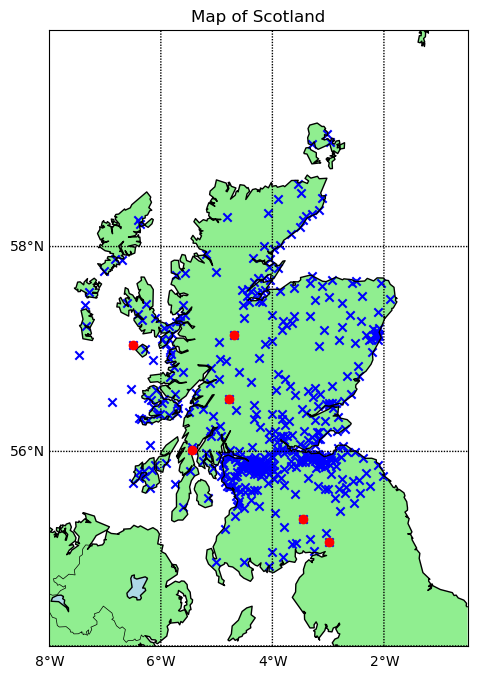

In [96]:
from mpl_toolkits.basemap import Basemap

# Create a map
plt.figure(figsize=(8, 8))
m = Basemap(projection='merc', 
            llcrnrlat=54, urcrnrlat=60.0, 
            llcrnrlon=-8.0, urcrnrlon=-0.5,
            resolution='i')

# Draw coastlines, countries, and fill land areas
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgreen', lake_color='lightblue')

# Draw parallels and meridians
m.drawparallels(range(50, 61, 2), labels=[1, 0, 0, 0])
m.drawmeridians(range(-10, 1, 2), labels=[0, 0, 0, 1])

# Add a title
plt.title('Map of Scotland')

# Show the map
m.scatter(candidates[candidates['CandidateId'].isin(new_array)]['longitude'],candidates[candidates['CandidateId'].isin(new_array)]['latitude'],latlon=True,marker='o', color='red', zorder=8)
m.scatter(customercord['longitude'],customercord['latitude'],latlon=True,marker='x', color='blue', zorder=1)
plt.show()

C:\Users\Nicolás Talia\AppData\Local\Temp\ipykernel_6268\1301223978.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  converted = transform(v36, v84, vlon36, vlat36)


,Customers,CustomerId,CustomerNorthing,CustomerEasting,longitude,latitude
0,1,AB10,805109,392949,-2.118129,57.136832
1,2,AB11,805438,394404,-2.094098,57.139808
2,3,AB12,800946,393407,-2.110451,57.099442
3,4,AB13,801808,385705,-2.237621,57.107009
4,5,AB14,801140,383616,-2.272063,57.100938


In [46]:
filtered_dict = {key: value for key, value in prob.getSolution(x).items() if value > 0}
filtered_dict

{'x_DG10_2_1': 1.0,
 'x_DG10_2_2': 1.0,
 'x_DG10_2_3': 1.0,
 'x_DG10_2_4': 1.0,
 'x_DG10_2_6': 1.0,
 'x_DG10_2_7': 1.0,
 'x_DG10_2_8': 1.0,
 'x_DG10_4_1': 1.0,
 'x_DG10_4_7': 1.0,
 'x_DG10_4_8': 1.0,
 'x_DG10_5_1': 1.0,
 'x_DG10_5_2': 1.0,
 'x_DG10_5_3': 1.0,
 'x_DG10_5_4': 1.0,
 'x_DG10_5_5': 1.0,
 'x_DG10_5_6': 1.0,
 'x_DG10_5_7': 1.0,
 'x_DG10_5_8': 1.0,
 'x_DG10_8_1': 1.0,
 'x_DG10_8_2': 1.0,
 'x_DG10_8_3': 1.0,
 'x_DG10_8_4': 1.0,
 'x_DG10_8_6': 1.0,
 'x_DG10_8_7': 1.0,
 'x_DG10_11_1': 1.0,
 'x_DG10_11_2': 1.0,
 'x_DG10_11_3': 1.0,
 'x_DG10_11_4': 1.0,
 'x_DG10_11_5': 1.0,
 'x_DG10_13_1': 1.0,
 'x_DG10_13_2': 1.0,
 'x_DG10_13_3': 1.0,
 'x_DG10_13_4': 1.0,
 'x_DG10_13_5': 1.0,
 'x_DG10_13_6': 1.0,
 'x_DG10_13_7': 1.0,
 'x_DG10_13_8': 1.0,
 'x_DG10_13_9': 1.0,
 'x_DG10_18_1': 1.0,
 'x_DG10_18_2': 1.0,
 'x_DG10_23_1': 1.0,
 'x_DG10_23_2': 1.0,
 'x_DG10_23_3': 1.0,
 'x_DG10_23_4': 1.0,
 'x_DG10_23_6': 1.0,
 'x_DG10_24_1': 1.0,
 'x_DG10_24_2': 1.0,
 'x_DG10_24_3': 1.0,
 'x_DG10_24_4': 